In [ ]:
import os
import glob
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

tf.random.set_seed(42)

In [ ]:
!pip install trimesh
import trimesh

     |████████████████████████████████| 634kB 7.6MB/s 


In [ ]:
!mkdir Trees
%cd Trees

!unzip -q /content/drive/MyDrive/Trees-dataset.zip

/content/Trees


In [ ]:
DATA_DIR ='/content/Trees'

In [ ]:
!mv Maple tree_Acer

In [ ]:
mesh = trimesh.load(os.path.join(DATA_DIR, "Betula/train/ID26.off"))
mesh.show()

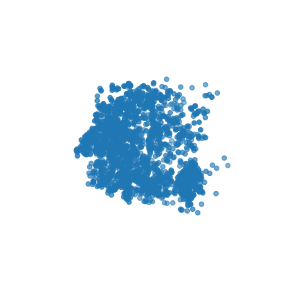

In [ ]:
points = mesh.sample(2048)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_axis_off()
plt.show()

In [ ]:
def parse_dataset(num_points=2048):

    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}
    folders = glob.glob(os.path.join(DATA_DIR, "[!README]*"))

    for i, folder in enumerate(folders):
        print("processing class: {}".format(os.path.basename(folder)))
        # store folder name with ID so we can retrieve later
        class_map[i] = folder.split("/")[-1]
        # gather all files
        train_files = glob.glob(os.path.join(folder, "train/*"))
        test_files = glob.glob(os.path.join(folder, "test/*"))

        for f in train_files:
            train_points.append(trimesh.load(f).sample(num_points))
            train_labels.append(i)

        for f in test_files:
            test_points.append(trimesh.load(f).sample(num_points))
            test_labels.append(i)

    return (
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
        class_map,
    )

In [ ]:
NUM_POINTS = 2048
NUM_CLASSES = 8
BATCH_SIZE = 32

train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_dataset(
    NUM_POINTS
)

processing class: Populus_tremula
processing class: Picea
processing class: Tilia
processing class: Betula
processing class: Quercus
processing class: Pinus
processing class: Populus
processing class: tree_Acer


In [ ]:
def augment(points, label):
    # jitter points
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    # shuffle points
    points = tf.random.shuffle(points)
    return points, label


train_dataset = tf.data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_points, test_labels))

train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)

In [ ]:
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)


def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

In [ ]:
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

In [ ]:
def tnet(inputs, num_features):

    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])

In [ ]:
inputs = keras.Input(shape=(NUM_POINTS, 3))

x = tnet(inputs, 3)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
model.summary()

Model: "pointnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2048, 3)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 2048, 32)     128         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 2048, 32)     128         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 2048, 32)     0           batch_normalization[0][0]        
___________________________________________________________________________________________

In [ ]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

history = model.fit(train_dataset, epochs=100, validation_data=test_dataset)

Epoch 1/100
7/7 [==============================] - 6s 232ms/step - loss: 2.8483 - sparse_categorical_accuracy: 0.3131 - val_loss: 48.5996 - val_sparse_categorical_accuracy: 0.0800
Epoch 2/100
7/7 [==============================] - 1s 148ms/step - loss: 2.8126 - sparse_categorical_accuracy: 0.3907 - val_loss: 3807.0371 - val_sparse_categorical_accuracy: 0.1000
Epoch 3/100
7/7 [==============================] - 1s 148ms/step - loss: 2.8602 - sparse_categorical_accuracy: 0.3939 - val_loss: 4.4180 - val_sparse_categorical_accuracy: 0.2000
Epoch 4/100
7/7 [==============================] - 1s 145ms/step - loss: 2.8805 - sparse_categorical_accuracy: 0.3324 - val_loss: 6.0822 - val_sparse_categorical_accuracy: 0.0800
Epoch 5/100
7/7 [==============================] - 1s 147ms/step - loss: 2.8108 - sparse_categorical_accuracy: 0.3693 - val_loss: 3.6149 - val_sparse_categorical_accuracy: 0.2400
Epoch 6/100
7/7 [==============================] - 1s 146ms/step - loss: 2.8968 - sparse_categorical_

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
history.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])

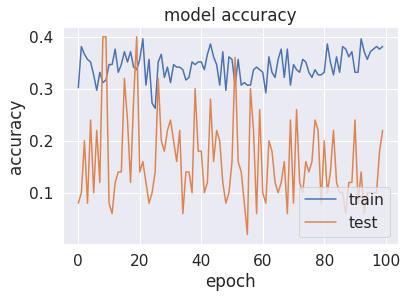

In [ ]:
# summarize history for accuracy
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show();

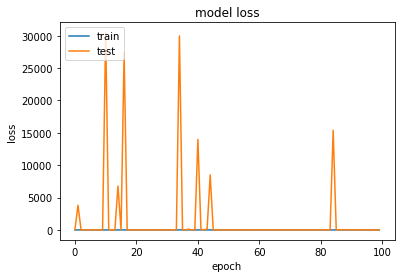

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
%cd ..

/content


In [ ]:
fname = 'weights (1).hdf5'
model.save_weights(fname, overwrite=True)

In [ ]:
fname = 'weights (1).hdf5'
model.load_weights(fname)

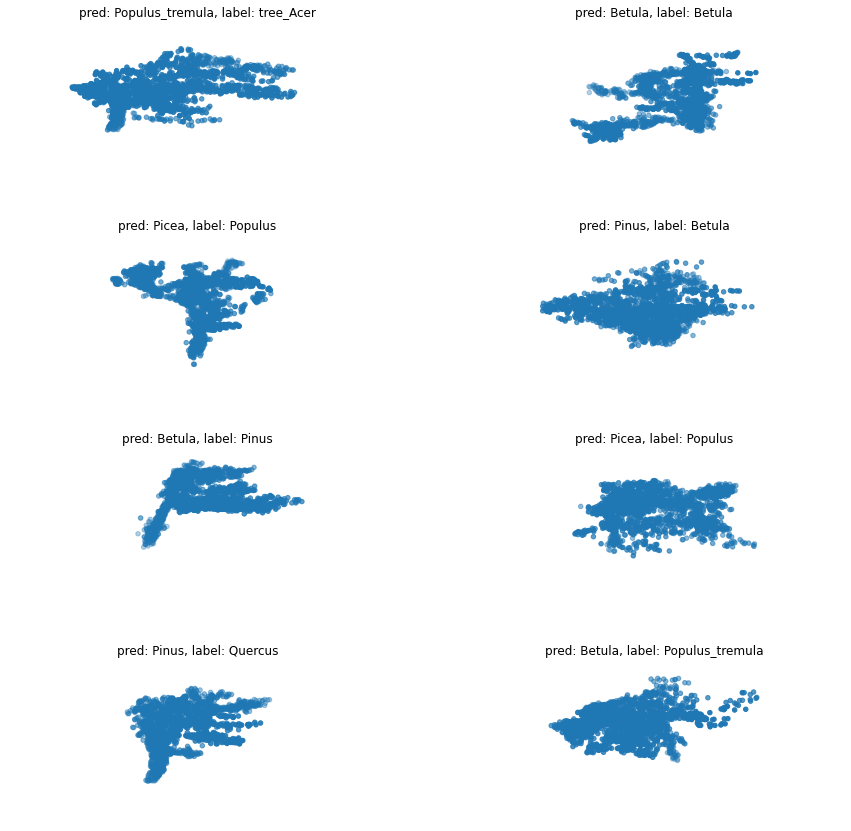

In [ ]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# run test data through model
preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 15))
for i in range(8):
    ax = fig.add_subplot(4, 2, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]]
        )
    )
    ax.set_axis_off()
plt.show()

In [ ]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [ ]:
data = test_dataset.take(1)
points, labels = list(data)[0]
points = points[:, ...]
labels = labels[:, ...]

# run test data through model
preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

In [ ]:
cm = confusion_matrix(y_true=labels, y_pred=preds)

In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
CLASS_MAP.values()

dict_values(['Populus_tremula', 'Picea', 'Tilia', 'Betula', 'Quercus', 'Pinus', 'Populus', 'tree_Acer'])

Confusion matrix, without normalization
[[0 0 0 2 0 0 0 1]
 [1 2 0 2 0 3 0 0]
 [0 0 0 0 0 1 0 0]
 [0 1 0 2 0 1 0 0]
 [0 0 0 1 0 1 0 1]
 [0 2 0 1 0 2 0 0]
 [1 2 0 1 1 1 0 0]
 [0 0 0 1 0 0 0 1]]


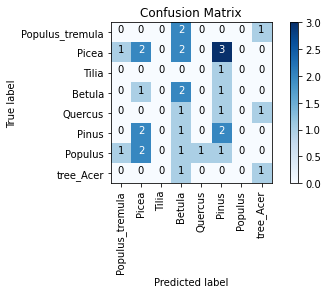

In [ ]:
plot_confusion_matrix(cm=cm, classes=CLASS_MAP.values(), title='Confusion Matrix')

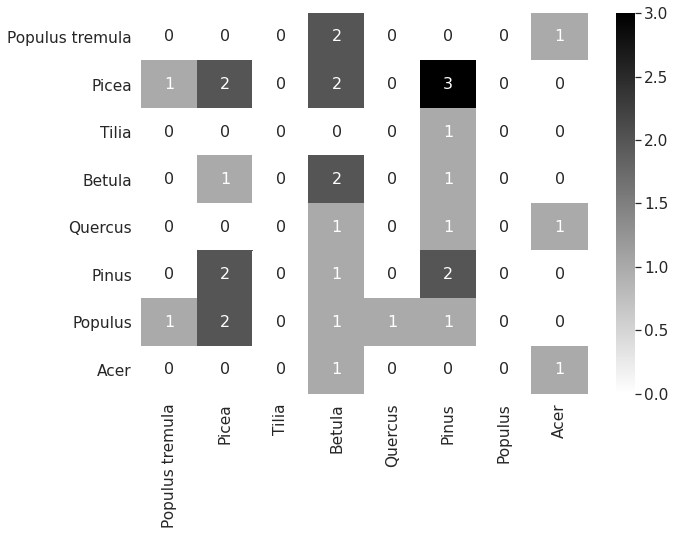

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array = [[0, 0, 0, 2, 0, 0, 0, 1],
         [1, 2, 0, 2, 0, 3, 0, 0],
         [0, 0, 0, 0, 0, 1, 0, 0],
         [0, 1, 0, 2, 0, 1, 0, 0],
         [0, 0, 0, 1, 0, 1, 0, 1],
         [0, 2, 0, 1, 0, 2, 0, 0],
         [1, 2, 0, 1, 1, 1, 0, 0],
         [0, 0, 0, 1, 0, 0, 0, 1]]


label_array = ['Populus tremula', 'Picea', 'Tilia', 'Betula', 'Quercus', 'Pinus', 'Populus', 'Acer']
df_cm = pd.DataFrame(array, label_array, label_array)
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap='binary') # font size

plt.show()

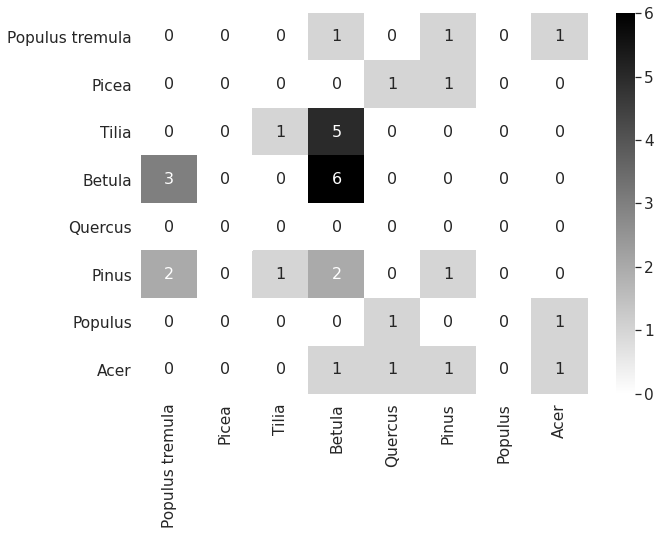

In [ ]:
array = [[0, 0, 0, 1, 0, 1, 0, 1],
         [0, 0, 0, 0, 1, 1, 0, 0],
         [0, 0, 1, 5, 0, 0, 0, 0],
         [3, 0, 0, 6, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0],
         [2, 0, 1, 2, 0, 1, 0, 0],
         [0, 0, 0, 0, 1, 0, 0, 1],
         [0, 0, 0, 1, 1, 1, 0, 1]]


label_array = ['Populus tremula', 'Picea', 'Tilia', 'Betula', 'Quercus', 'Pinus', 'Populus', 'Acer']
df_cm = pd.DataFrame(array, label_array, label_array)
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap='binary') # font size

plt.show()